In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, load_model
from hmpai.pytorch.generators import SAT1Dataset
from hmpai.visualization import plot_confusion_matrix, plot_max_activation_per_label, add_attribution, plot_model_attention_over_stage_duration
from hmpai.normalization import *
from torchinfo import summary
from hmpai.utilities import print_results, CHANNELS_2D, REINDEX_CHANNELS_AR, AR_SAT1_CHANNELS
from torch.utils.data import DataLoader, ConcatDataset
from hmpai.data import SAT1_STAGES_ACCURACY, AR_STAGES, SAT1_STAGES_SPEED, COMMON_STAGES
import scipy
from captum.attr import IntegratedGradients
from mne.io import read_info
import mne
import numpy as np

### Load datasets

In [2]:
set_global_seed(42)
data_path = Path("../data/ar/split_stage_data.nc")
dataset = xr.load_dataset(data_path)
data_path_sat1 = Path("../data/sat1/split_stage_data_100hz.nc")
dataset_sat1 = xr.load_dataset(data_path_sat1)

In [6]:
dataset["labels"] = [
    "decision_ar",
    "encoding_ar",
    "familiarity_ar",
    "memory_ar",
    "pre-attentive_ar",
    "response_ar",
]
dataset_sat1["labels"] = [
    "confirmation_sat",
    "decision_sat",
    "encoding_sat",
    "pre-attentive_sat",
    "response_sat",
]

In [4]:
# Switch encoding and decision
# dataset['labels'] = ['encoding', 'decision', 'familiarity', 'memory', 'pre-attentive',
#        'response']
# dataset_labels = list(dataset_sat1['labels'].values)
# dataset_labels.reverse()
# dataset_sat1['labels'] = dataset_labels

<xarray.DataArray 'labels' (labels: 5)>
array(['confirmation', 'decision', 'encoding', 'pre-attentive', 'response'],
      dtype=object)
Coordinates:
  * labels   (labels) object 'confirmation' 'decision' ... 'response'

In [3]:
# Re-order channels to be as similar as possible to SAT1
# dataset = dataset.reindex(channels=REINDEX_CHANNELS_AR).drop_sel(
#     channels=["trash1", "trash2"]
# )
dataset = dataset.reindex(channels=AR_SAT1_CHANNELS)
# Labels in both SAT1 and AR
# common_labels = list(set(SAT1_STAGES_ACCURACY).union(set(AR_STAGES)))
# Labels in either SAT1 or AR
# common_labels = list(set(dataset.labels.values).union(set(dataset_sat1.labels.values)))

# dataset = dataset.sel(labels=common_labels)
dataset_sat1["channels"] = [c.upper() for c in dataset_sat1["channels"].values]
dataset_sat1 = dataset_sat1.reindex(channels=AR_SAT1_CHANNELS)

In [4]:
shape_topological = False
train_data, val_data, test_data = split_data_on_participants(
    dataset, 60, norm_min1_to_1
)
shape_topological = False
train_data_sat1, val_data_sat1, test_data_sat1 = split_data_on_participants(
    dataset_sat1, 60, norm_min1_to_1
)

In [5]:
train_merge = xr.merge([train_data, train_data_sat1])
val_merge = xr.merge([val_data, val_data_sat1])
test_merge = xr.merge([test_data, test_data_sat1])

In [15]:
train_dataset = SAT1Dataset(
    train_merge, shape_topological=shape_topological, labels=COMMON_STAGES
)
val_dataset = SAT1Dataset(
    val_merge, shape_topological=shape_topological, labels=COMMON_STAGES
)
test_dataset = SAT1Dataset(
    test_merge, shape_topological=shape_topological, labels=COMMON_STAGES
)

In [7]:
model = SAT1GRU(
    len(train_merge.channels), len(train_merge.samples), len(train_merge.labels)
)

/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [10]:
train_and_test(
    model,
    train_dataset,
    test_dataset,
    val_dataset,
    logs_path=Path("../logs/"),
    workers=4,
    batch_size=128,
    use_class_weights=True,
)

  0%|          | 0/485 [00:00<?, ? batch/s]

  0%|          | 0/485 [00:00<?, ? batch/s]

  0%|          | 0/485 [00:00<?, ? batch/s]

  0%|          | 0/485 [00:00<?, ? batch/s]

  0%|          | 0/485 [00:00<?, ? batch/s]

  0%|          | 0/485 [00:00<?, ? batch/s]

  0%|          | 0/485 [00:00<?, ? batch/s]

  0%|          | 0/485 [00:00<?, ? batch/s]

  0%|          | 0/485 [00:00<?, ? batch/s]

  0%|          | 0/485 [00:00<?, ? batch/s]

  0%|          | 0/485 [00:00<?, ? batch/s]

  0%|          | 0/485 [00:00<?, ? batch/s]

  0%|          | 0/485 [00:00<?, ? batch/s]

{'0': {'precision': 0.8724018475750578,
  'recall': 0.8238822246455835,
  'f1-score': 0.8474481211441391,
  'support': 3668.0},
 '1': {'precision': 0.8758494511238892,
  'recall': 0.8964686998394864,
  'f1-score': 0.8860391327340031,
  'support': 3738.0},
 '2': {'precision': 0.9067039106145252,
  'recall': 0.8683788121990369,
  'f1-score': 0.8871276305001365,
  'support': 3738.0},
 '3': {'precision': 0.8909432779692886,
  'recall': 0.7605671482075976,
  'f1-score': 0.8206090344927117,
  'support': 3738.0},
 '4': {'precision': 0.6666666666666666,
  'recall': 0.9230769230769231,
  'f1-score': 0.7741935483870968,
  'support': 455.0},
 '5': {'precision': 0.890268456375839,
  'recall': 0.9361326746647848,
  'f1-score': 0.912624699002408,
  'support': 2834.0},
 '6': {'precision': 0.7939412117576484,
  'recall': 0.934015525758645,
  'f1-score': 0.8583009079118028,
  'support': 2834.0},
 'accuracy': 0.8656034277552963,
 'macro avg': {'precision': 0.8423964031547022,
  'recall': 0.8775031440560

In [16]:
test_loader = DataLoader(
    test_dataset, 128, shuffle=True, num_workers=4, pin_memory=True
)
results, pred, true = test(model, test_loader, None)
pred = pred.cpu()

In [11]:
common_labels = [
    "pre-attentive_sat",
    "pre-attentive_ar",
    "encoding_sat",
    "encoding_ar",
    "decision_sat",
    "decision_ar",
    "response_sat",
    "response_ar",
    "confirmation_sat",
    "familiarity_ar",
    "memory_ar",
]

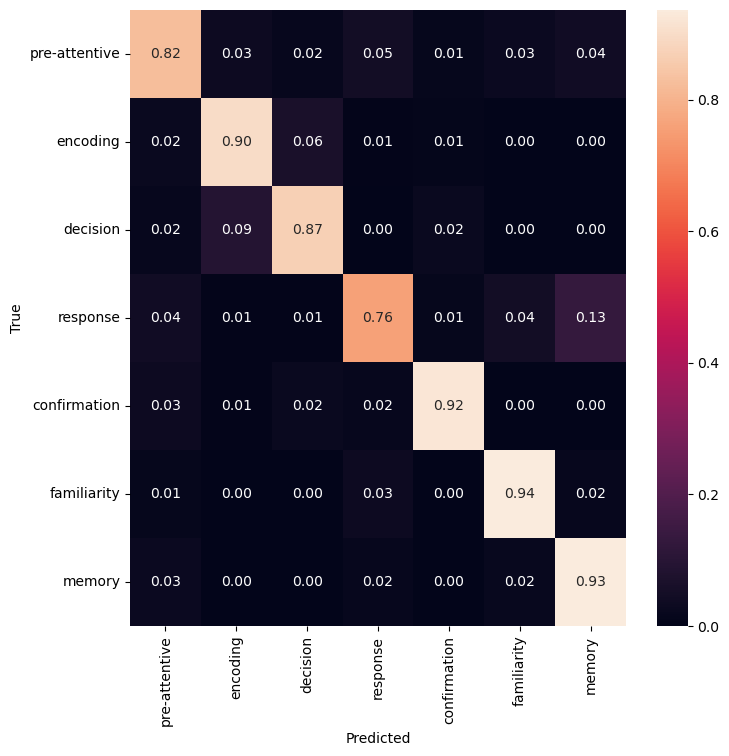

In [17]:
plot_confusion_matrix(true, pred, COMMON_STAGES)

In [16]:
torch.backends.cudnn.enabled = False
model = model.eval()
ig = IntegratedGradients(model.forward)
attributions = add_attribution(test_merge, ig, model)
info_path = Path("../data/sat1/preprocessed/processed_0001_epo.fif")

  0%|          | 0/743 [00:00<?, ?it/s]

In [17]:
positions = read_info(info_path)
positions.rename_channels({c: c.upper() for c in positions.ch_names})
indices = mne.pick_channels(positions["ch_names"], include=AR_SAT1_CHANNELS)
positions = mne.pick_info(positions, indices)

/tmp/ipykernel_5002/1476991676.py:3: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  indices = mne.pick_channels(positions["ch_names"], include=AR_SAT1_CHANNELS)


In [57]:
AR_indices = []
SAT_indices = []
for i, index in enumerate(attributions.index.values):
    if index[0].startswith("AR"):
        AR_indices.append(i)
    else:
        SAT_indices.append(i)

In [58]:
attributions_ar = attributions.isel(index=AR_indices)
attributions_sat = attributions.isel(index=SAT_indices)

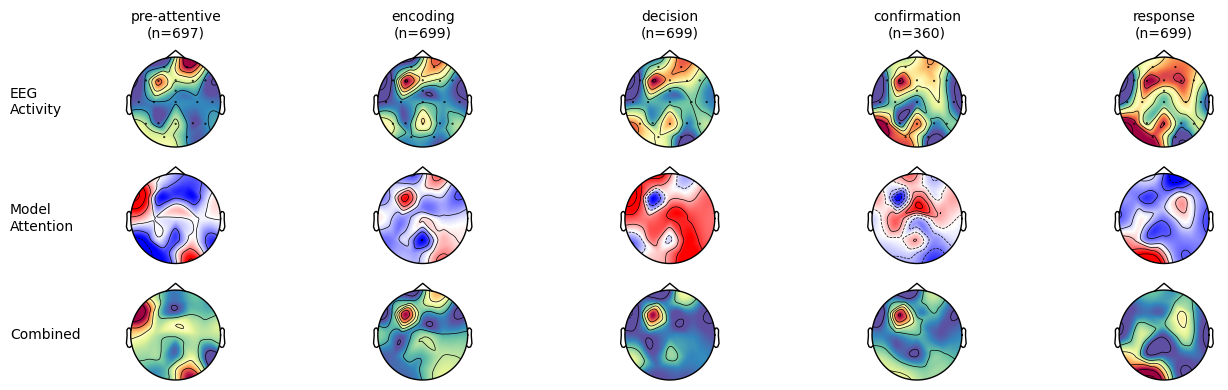

In [63]:
plot_max_activation_per_label(attributions_sat, positions, labels=SAT1_STAGES_ACCURACY)

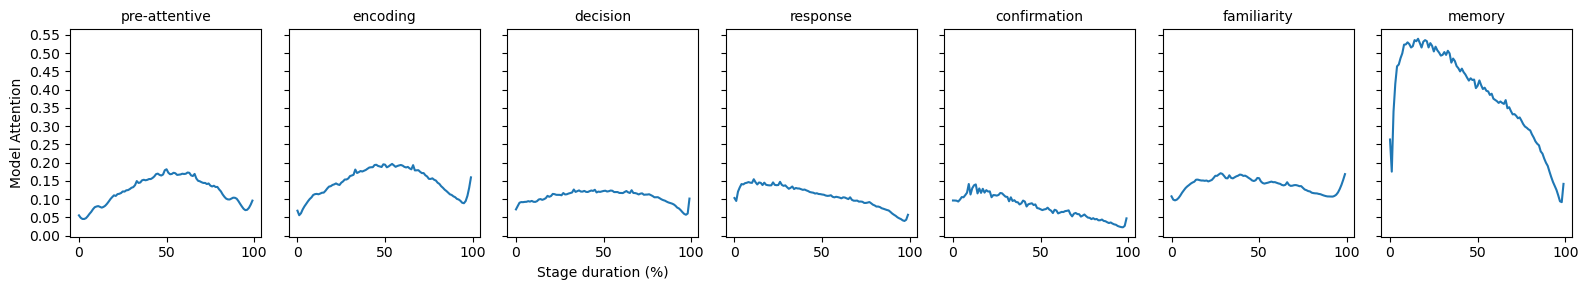

In [21]:
plot_model_attention_over_stage_duration(attributions, labels=common_labels)